In [1]:
from finlab.data import Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy as np
data = Data()
price = data.get('收盤價',500)
%matplotlib inline

In [9]:
# selects = ['0050' ,'1730','9945','2912']
#selects = ['0050','1410', '1615', '1783', '2337', '3019', '3090', '4968', '5534', '6277', '8481', '9937']
selects = ['0050' ,'0056' , '2886' , '2891' , '2412']
table = price[selects[0:len(selects)]]
table.head()

stock_id,0050,0056,2886,2891,2412
date,,,,,
2016-12-27,70.75,22.86,22.85,17.50,101.0
2016-12-28,71.60,23.00,23.00,17.60,101.5
2016-12-29,71.25,22.99,22.80,17.55,101.5
2016-12-30,71.80,23.07,23.00,17.65,101.5
2017-01-03,71.90,23.12,23.10,17.70,102.5


In [10]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252 #trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate,n_stocks):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(n_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
#simple returns
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178
n_stocks = len(selects)

In [11]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate , n_stocks)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [12]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate,n_stocks)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.13


stock_id    0050  0056   2886   2891  2412
allocation  1.03  0.99  53.49  40.77  3.71
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.05
Annualised Volatility: 0.09


stock_id    0050   0056   2886  2891   2412
allocation   0.4  41.16  15.27  1.48  41.69


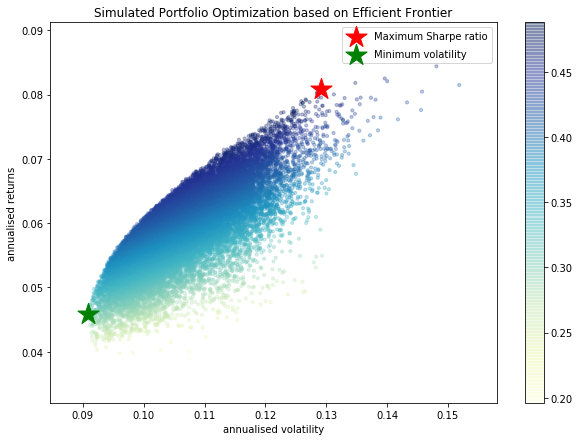

In [13]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks)

In [8]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.2


stock_id    0050  1410  1615  1783  2337   3019   3090  4968   5534  6277  \
allocation   0.0   0.0  9.36   0.0  8.01  11.49  21.75   0.0  28.57   0.0   

stock_id    8481   9937  
allocation   0.0  20.82  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.08


stock_id    0050   1410  1615  1783  2337  3019  3090  4968  5534   6277  \
allocation  17.7  10.21   0.0  0.09   0.0   0.0   0.0   0.0  2.19  13.38   

stock_id    8481   9937  
allocation  5.65  50.78  


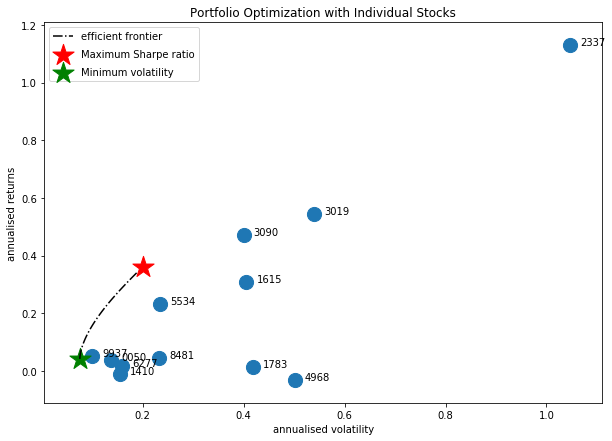

In [8]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks)

In [46]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate,n_stocks)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    
    
    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.21


stock_id    0050  1410  1615  1783  2337   3019   3090  4968   5534  6277  \
allocation   0.0   0.0   8.3   0.0   9.2  11.55  24.14   0.0  24.83   0.0   

stock_id    8481   9937  
allocation   0.0  21.98  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.08




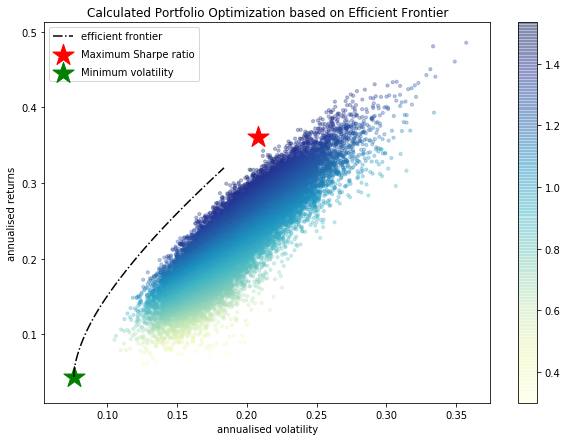

In [47]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks)

In [48]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

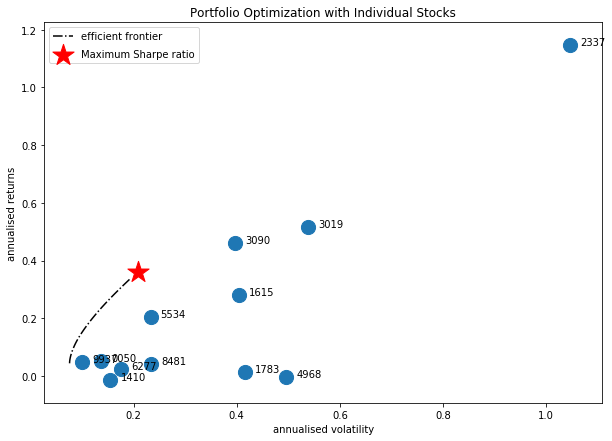

In [49]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [56]:
import statsmodels.api as smi
from statsmodels import regression
import scipy as sp

def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])


def sharpe_ratio(return_list):
    '''夏普比率'''
    average_return = np.mean(return_list)
    return_stdev = np.std(return_list)
    sharpe_ratio = (AnnualRet-0.01) * np.sqrt(252)  / AnnualVol  #默认252个工作日,无风险利率为0.01 ->銀行定存
    return sharpe_ratio

# x = returns['0050'].values[1:]
# y = returns['1730'].values[1:]
def Calculate_alpha_and_beta(x,y):
    x =  smi.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    x = x[: , 1]
    return model.params[0] , model.params[1]
# alpha , beta = linreg(x,y)
all_beta = []
all_alpha = []
benchmark  = returns['0050'].values[1:]
x = benchmark
# for colume in returns.columns:
#     y = returns[colume].values[1:]
#     alpha , beta  = Calculate_alpha_and_beta( x,y )
#     all_beta.append(beta)
#     all_alpha.append(alpha)
def display_SML_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(n_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    returns = np.sum(mean_returns*weights ) *252 #trading days
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
#     print("-"*80)
#     print("Maximum Sharpe Ratio Portfolio Allocation\n")
#     print("Annualised Return:", round(rp,2))
#     print("Annualised Volatility:", round(sdp,2))
#     print("\n")
#     print(max_sharpe_allocation)
#     print("-"*80)
#     print("Minimum Volatility Portfolio Allocation\n")
#     print("Annualised Return:", round(rp_min,2))
#     print("Annualised Volatility:", round(sdp_min,2))
#     print("\n")
#     print(min_vol_allocation)
    all_beta = []
    all_alpha = []
    benchmark  = returns['0050'].values[1:]
    x = benchmark
    for colume in returns.columns:
        y = returns[colume].values[1:]
        alpha , beta = Calculate_alpha_and_beta( x,y )
        all_beta.append(beta)
        all_alpha.append(alpha)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(all_beta,an_rt,marker='o',s=200)
    ax.plot([0,1],[0.01, an_rt[0]] , color = 'orange' , linestyle = '-' , label = 'Securities market line')
    total_alpha = pd.DataFrame(all_alpha , index = table.columns , columns=['Individual'])
    total_alpha = total_alpha.T
    total_alpha
    print('-'*80)
    print('alpha values\n')
    print(total_alpha)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (all_beta[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
#     ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
#     ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

#     target = np.linspace(rp_min, 0.34, 50)
#     efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
#     ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Beta  with Individual Stocks')
    ax.set_xlabel('annualised beta')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    

display_SML_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks)

IndexError: invalid index to scalar variable.

In [79]:
    
# max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
# sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
# max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])


stock_id        0050      1730      9945      2912
Individual  0.000663  0.000663  0.000663  0.000663
